# ⚠️ Hot Jupiter Phase Curve Example

In [1]:
%matplotlib inline

In [2]:
import starry
import matplotlib.pyplot as plt
import numpy as np
import exoplanet as xo
import pymc3 as pm
import theano.tensor as tt
import theano
theano.config.optimizer = "None"

Compiling `render`... Done.


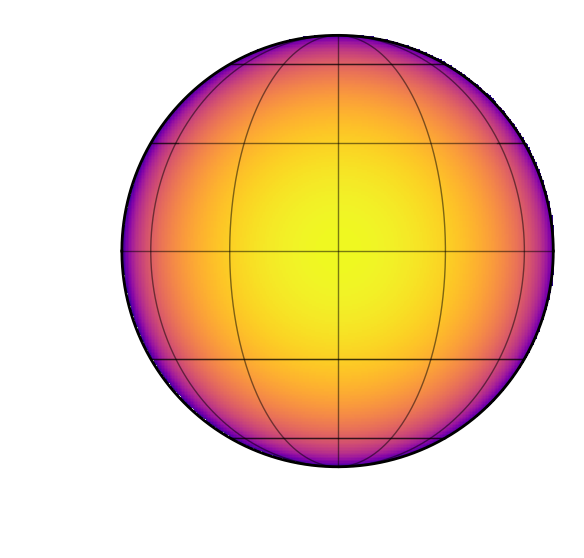

In [3]:
A = starry.Primary(
    starry.Map(ydeg=0, udeg=2, L=1.0, inc=90.0, obl=0.0),
    m=1.0,
    r=1.0,
    prot=1.0
)
A.map[1] = 0.4
A.map[2] = 0.2
A.map.show()

In [4]:
b = starry.Secondary(
    starry.Map(ydeg=1, udeg=0, L=0.001, inc=90.0, obl=0.0),
    m=0.0,
    r=0.1,
    prot=1.0,
    porb=1.0
)
b.map[1, 0] = 0.5
offset = 10.0
b.theta0 = 180.0 + offset

Compiling `render`... Done.


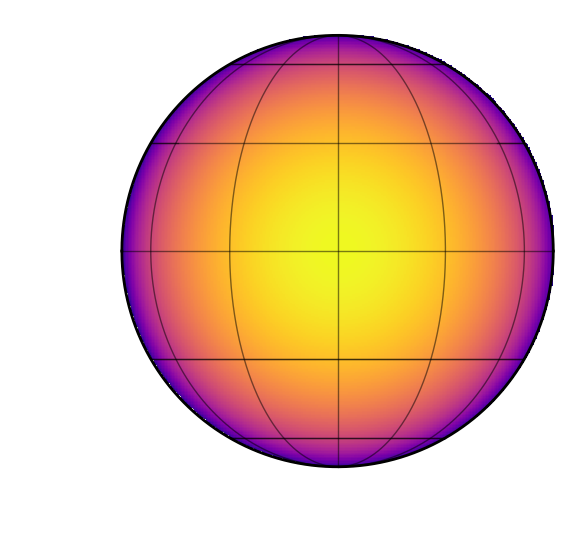

In [5]:
b.map.show()

In [6]:
sys = starry.System(A, b)

/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


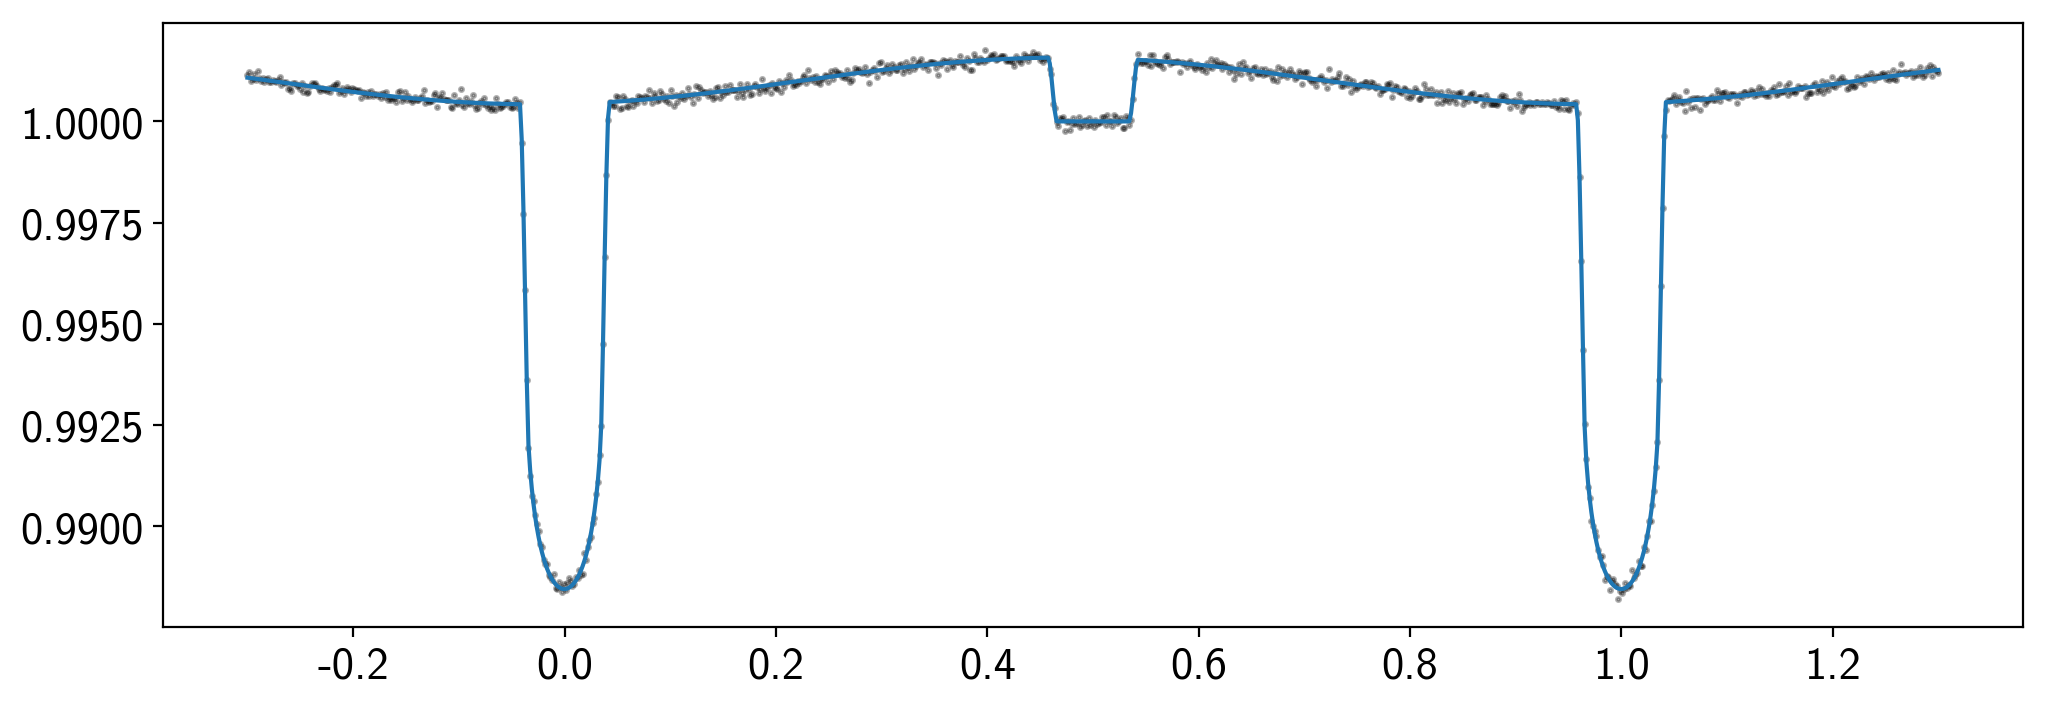

In [7]:
t = np.linspace(-0.3, 1.3, 1000)
flux_true = sys.flux(t).eval()
ferr = 1e-4
flux = flux_true + ferr * np.random.randn(len(t))
plt.plot(t, flux, "k.", alpha=0.3, ms=3)
plt.plot(t, flux_true);

In [11]:
with pm.Model() as model:
    
    offset = pm.Normal("offset", 0.0, 30.0, testval=0.11)
    log_L = pm.Normal("log_L", -4.0, 2.0, testval=-3.91)
    
    A = starry.Primary(
        starry.Map(ydeg=0, udeg=2, L=1.0, inc=90.0, obl=0.0),
        m=1.0,
        r=1.0,
        prot=1.0
    )
    A.map[1] = 0.4
    A.map[2] = 0.2

    b = starry.Secondary(
        starry.Map(ydeg=1, udeg=0, L=10 ** log_L, inc=90.0, obl=0.0),
        m=tt.as_tensor_variable(0.0).astype("float64"),
        r=0.1,
        prot=1.0,
        porb=1.0
    )
    b.map[1, 0] = 0.5
    b.theta0 = 180.0 + offset
    
    sys = starry.System(A, b)
    
    flux_model = pm.Deterministic("flux_model", sys.flux(t))
    
    pm.Normal("obs", flux_model, sd=ferr, observed=flux)

/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


In [12]:
with model:
    map_soln = xo.optimize()

/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
optimizing logp for variables: ['log_L', 'offset']
73it [00:00, 228.89it/s, logp=7.809526e+03]/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
76it [00:00, 228.89it/s, logp=7.809526e+03]/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequ

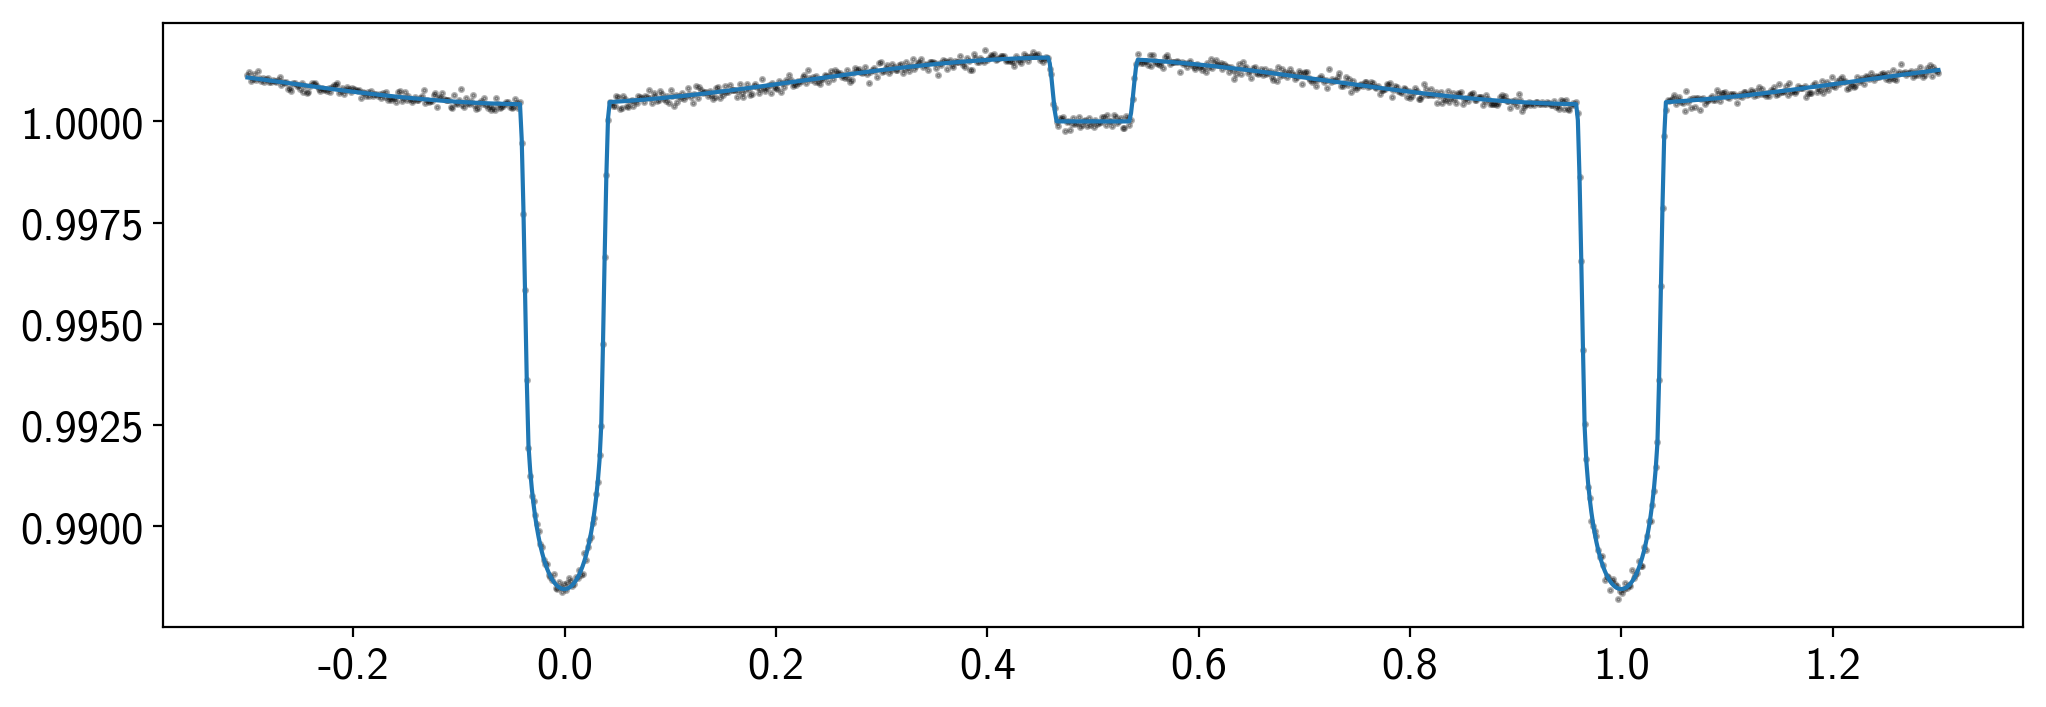

In [13]:
plt.plot(t, flux, "k.", alpha=0.3, ms=3)
plt.plot(t, map_soln["flux_model"]);

In [15]:
sampler = xo.PyMC3Sampler(window=100, finish=200, cores=1)
with model:
    burnin = sampler.tune(tune=2000, start=map_soln, step_kwargs=dict(target_accept=0.9))
    trace = sampler.sample(draws=2000)

/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
100%|██████████| 202/202 [00:03<00:00, 58.03it/s]
Sequential sampling (2 chains in 1 job)
NUTS: [log_L, offset]
100%|██████████| 2000/2000 [00:37<00:00, 52.85it/s]


In [19]:
pm.summary(trace, varnames=["log_L", "offset"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
log_L,-2.999498,0.001518,0.000027,-3.002516,-2.996522,3505.309307,0.999777
offset,9.641992,0.437289,0.008112,8.841363,10.534026,3339.964702,0.999760


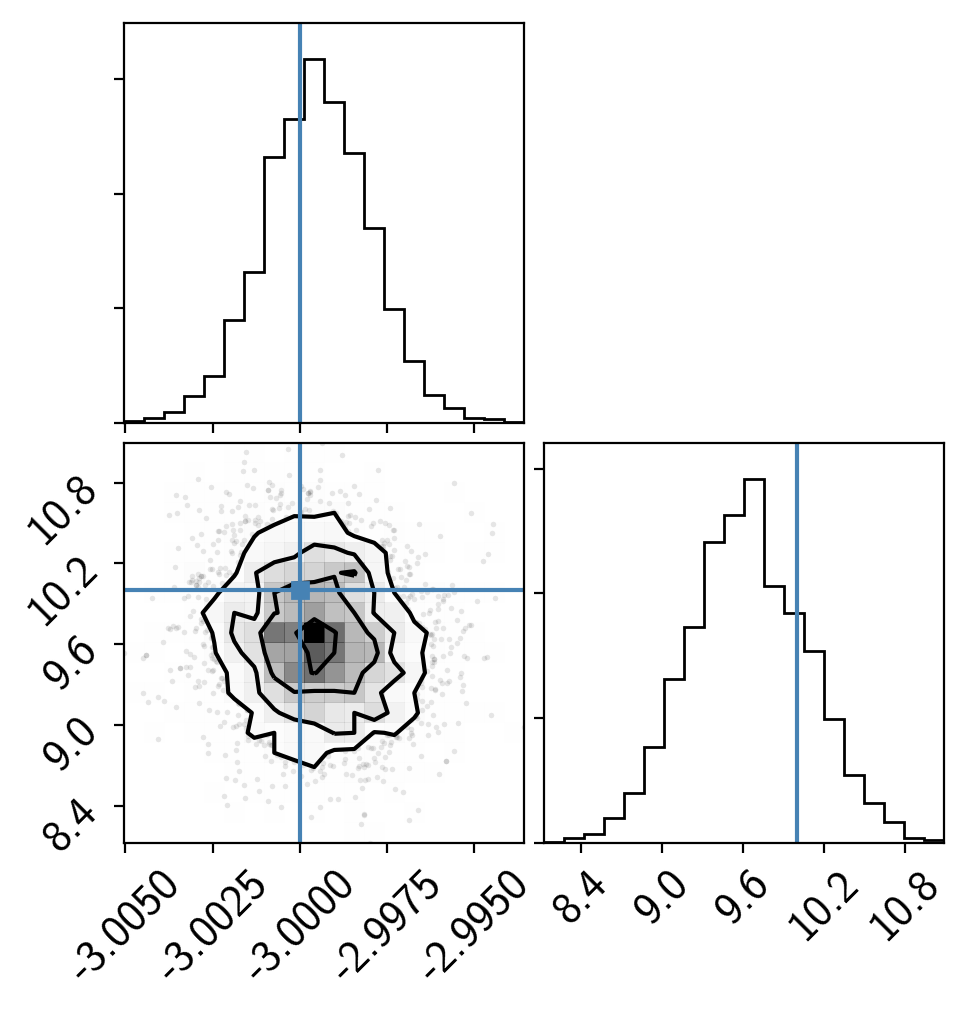

In [21]:
import corner
samples = pm.trace_to_dataframe(trace, varnames=["log_L", "offset"])
corner.corner(np.array(samples), truths=[-3, 10]);